In [ ]:
# Dataset prepare
import gdown

In [ ]:
# get the database from google drive 
!gdown --id 1cNON195HScaG3Tne14DThbGaBaviLcAh # Amazon Beauty Product Review 
!gdown --id 1DRgp5L7RdrbFst2r8HZ3DRog1wn1HVB3 # Youtube Comments 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1cNON195HScaG3Tne14DThbGaBaviLcAh 

Downloading...
From: https://drive.google.com/uc?id=1DRgp5L7RdrbFst2r8HZ3DRog1wn1HVB3
To: /content/youtube_dataset.csv
100% 5.17M/5.17M [00:00<00:00, 18.6MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 57.7 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 6.8 MB 31.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
import tokenizers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# NLP packages - for youtube comment dataset
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# import subprocess
# print(subprocess.getoutput('nvidia-smi'))
!nvidia-smi

Wed Feb 23 13:57:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as func

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [ ]:
COLOR_PALETTE = ["#FFBA00",'#F56F02','#CB1F47','#645DAC','#0088D2','#00B345']

In [ ]:
sns.set_palette(sns.color_palette(COLOR_PALETTE))

In [ ]:
rcParams['figure.figsize'] = 12, 8

In [ ]:
RANDOM_SEED = 42

In [ ]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Filepath
fp = r"/content/drive/My Drive/All_Beauty.json"

In [ ]:
df = pd.read_json(fp, lines=True)
# df = pd.read_json("All_Beauty.json", lines=True)
df1 = pd.read_csv("youtube_dataset.csv", error_bad_lines=False)

In [ ]:
df.shape

(371345, 12)

In [ ]:
df1.shape

(19300, 7)

In [ ]:
# Size down little bit of amazon review dataset
df = df.sample(frac=0.10, replace=True).reset_index(drop = True)

In [ ]:
df1 = df1.sample(frac=0.20, replace=True).reset_index(drop = True)

In [ ]:
df.shape

(37134, 12)

In [ ]:
df1.shape

(3860, 7)

In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,4,True,"03 29, 2017",AUGIN02JXHF8V,B0091OCDRE,Rebecca P.,I have super sensitive acne prone skin. I love...,"Love the brand, but prefer their clarifying line",1490745600,NaN,{'Style Name:': ' 1000 Roses'},NaN
1,5,True,"02 22, 2014",A24TXVWKBRAZ07,B00EC21OIE,Shelia,This is the best invention since electricity!!,10 second neck lift!,1393027200,NaN,NaN,NaN
2,4,True,"08 10, 2013",A24C4ZIB26DH0Z,B000FOI48G,desertmirage412,I am using it to clean through braces. it is s...,love it!,1376092800,NaN,NaN,NaN
3,3,True,"11 4, 2017",A1VBVKYHBXUXJT,B01FHDYGQ8,The empathetic muse,Serves the purpose but cat throw in your bag w...,Decent but not durable,1509753600,NaN,NaN,NaN
4,1,True,"01 7, 2011",AY5S3YO7FNDSN,B000F0BXLK,SPGryphon,I had high hopes for this travel brush. I'm a...,High Hopes,1294358400,NaN,NaN,NaN


In [ ]:
df1.head()

,Video Name,Channel Name,Comment Id,User Name,Comment,Date,Likes
0,Pharrell Williams - Happy (Official Music Video),iamOTHER,UgiifN2Z6riq0XgCoAEC,Ann Le,Got the Monday blues? Love this song!!,2013-11-26T01:52:41Z,94
1,The Weeknd - Starboy ft. Daft Punk (Official V...,TheWeekndVEVO,UgxLOcRY0wU9MMHsQAt4AaABAg,Reyna Everdeen,Am i the only one that came back after listeni...,2020-09-07T09:15:34Z,1
2,Taylor Swift - Look What You Made Me Do,TaylorSwiftVEVO,UgwyPRgK2sGttbTtmQR4AaABAg,grace,can’t believe this was over three years ago,2020-09-07T23:00:34Z,2
3,BLACKPINK - ‘뚜두뚜두 (DDU-DU DDU-DU)’ M/V,BLACKPINK,Ugzxf60tJaEcfdgUVhd4AaABAg,heon park,I love jisoo,2019-11-24T08:23:40Z,14984
4,PSY - GENTLEMAN M/V,officialpsy,UgyOdhpzKIqewlzwqkx4AaABAg,Crystal Zoey,kim jon un when he imagines what his life woul...,2020-08-23T23:42:26Z,1


In [ ]:
# before combine two dataset, need overall score for comment 
# Testing NLP - Sentiment Analysis using TextBlob
TextBlob("I'm not sure know this product helps me").sentiment

Sentiment(polarity=-0.25, subjectivity=0.8888888888888888)

In [ ]:
# Calculating the Sentiment Polarity
pol = [] # list which will contain the polarity of the comments
for i in df1.Comment.values:
    try:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
  
    except:
        pol.append(0)

In [ ]:
# Adding the Sentiment Polarity column to the dataset
df1['overall'] = pol

In [ ]:
# from pandas.core.groupby.generic import DataFrameGroupBy
# Converting the polarity values from continuous to categorical
# df1['overall'][df1.overall == 0] = 1
# df1['overall'][df1.overall > 0] = 2
# df1['overall'][df1.overall < 0] = 0

In [ ]:
# create dataset 
youtube_df = df1[['Comment', 'overall']].copy()

In [ ]:
# check the youtube comment dataset 
youtube_df.head()

,Comment,overall
0,Got the Monday blues? Love this song!!,0.78125
1,Am i the only one that came back after listeni...,0.00000
2,can’t believe this was over three years ago,0.00000
3,I love jisoo,0.50000
4,kim jon un when he imagines what his life woul...,0.00000


In [ ]:
# their's hugely imbalanced, we going to convert the dataset into negative, neutral and positive sntiment
def sentiment(rating):
    rating = float(rating)
    if rating < 0:
        return 0 
    elif rating == 0:
        return 1
    else:
        return 2

youtube_df['sentiment'] = youtube_df.overall.apply(sentiment)

In [ ]:
class_name = ['negative', 'neutral', 'positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

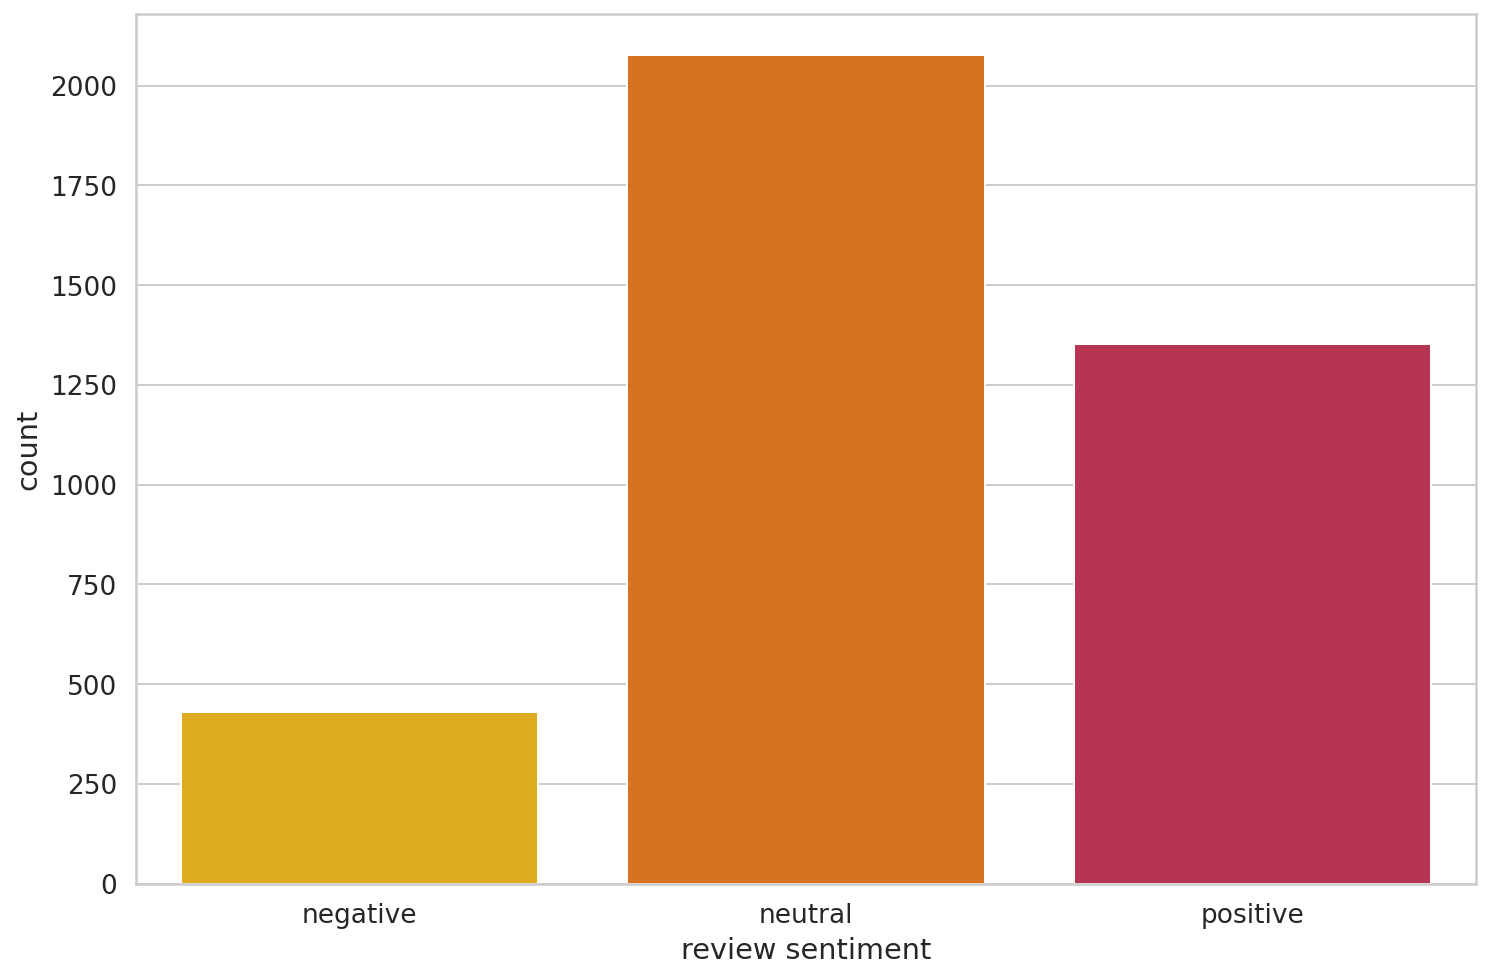

In [ ]:
ax = sns.countplot(youtube_df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_name)

In [ ]:
df.shape

(37134, 12)

In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,4,True,"03 29, 2017",AUGIN02JXHF8V,B0091OCDRE,Rebecca P.,I have super sensitive acne prone skin. I love...,"Love the brand, but prefer their clarifying line",1490745600,NaN,{'Style Name:': ' 1000 Roses'},NaN
1,5,True,"02 22, 2014",A24TXVWKBRAZ07,B00EC21OIE,Shelia,This is the best invention since electricity!!,10 second neck lift!,1393027200,NaN,NaN,NaN
2,4,True,"08 10, 2013",A24C4ZIB26DH0Z,B000FOI48G,desertmirage412,I am using it to clean through braces. it is s...,love it!,1376092800,NaN,NaN,NaN
3,3,True,"11 4, 2017",A1VBVKYHBXUXJT,B01FHDYGQ8,The empathetic muse,Serves the purpose but cat throw in your bag w...,Decent but not durable,1509753600,NaN,NaN,NaN
4,1,True,"01 7, 2011",AY5S3YO7FNDSN,B000F0BXLK,SPGryphon,I had high hopes for this travel brush. I'm a...,High Hopes,1294358400,NaN,NaN,NaN


In [ ]:
df.isna().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          5
reviewText           39
summary              17
unixReviewTime        0
vote              31808
style             24667
image             36301
dtype: int64

In [ ]:
# create dataset 
amazon_df = df[['reviewText', 'overall']].copy()

In [ ]:
# Amazon dataset processing
amazon_df.isna().sum()

reviewText    39
overall        0
dtype: int64

In [ ]:
amazon_df.dropna(inplace=True)

In [ ]:
amazon_df.isna().sum()

reviewText    0
overall       0
dtype: int64

In [ ]:
amazon_df.shape

(37095, 2)

In [ ]:
# ratings across dataset
rating_pct = amazon_df['overall'].value_counts()/len(df) * 100

In [ ]:
rating_pct

5    61.738568
4    14.172995
1    10.507890
3     8.057306
2     5.418215
Name: overall, dtype: float64

Text(0.5, 0, 'star score')

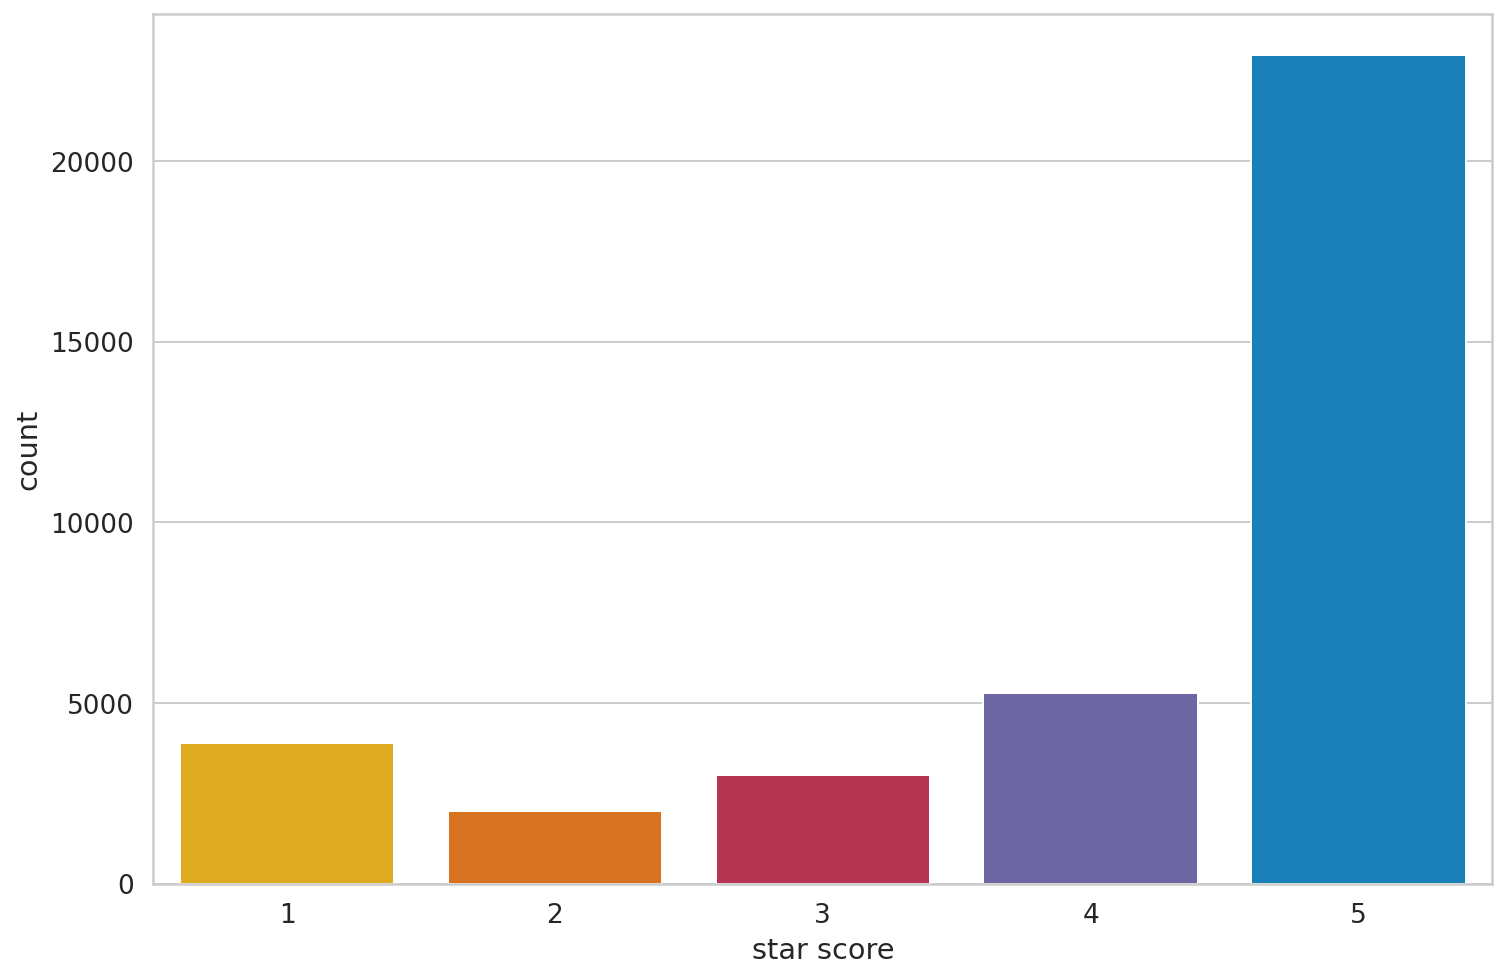

In [ ]:
# class imbalance 
sns.countplot(amazon_df.overall)
plt.xlabel('star score')

In [ ]:
# their's hugely imbalanced, we going to convert the dataset into negative, neutral and positive sntiment
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0 
    elif rating <= 4:
        return 1
    else:
        return 2

amazon_df['sentiment'] = amazon_df.overall.apply(to_sentiment)

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

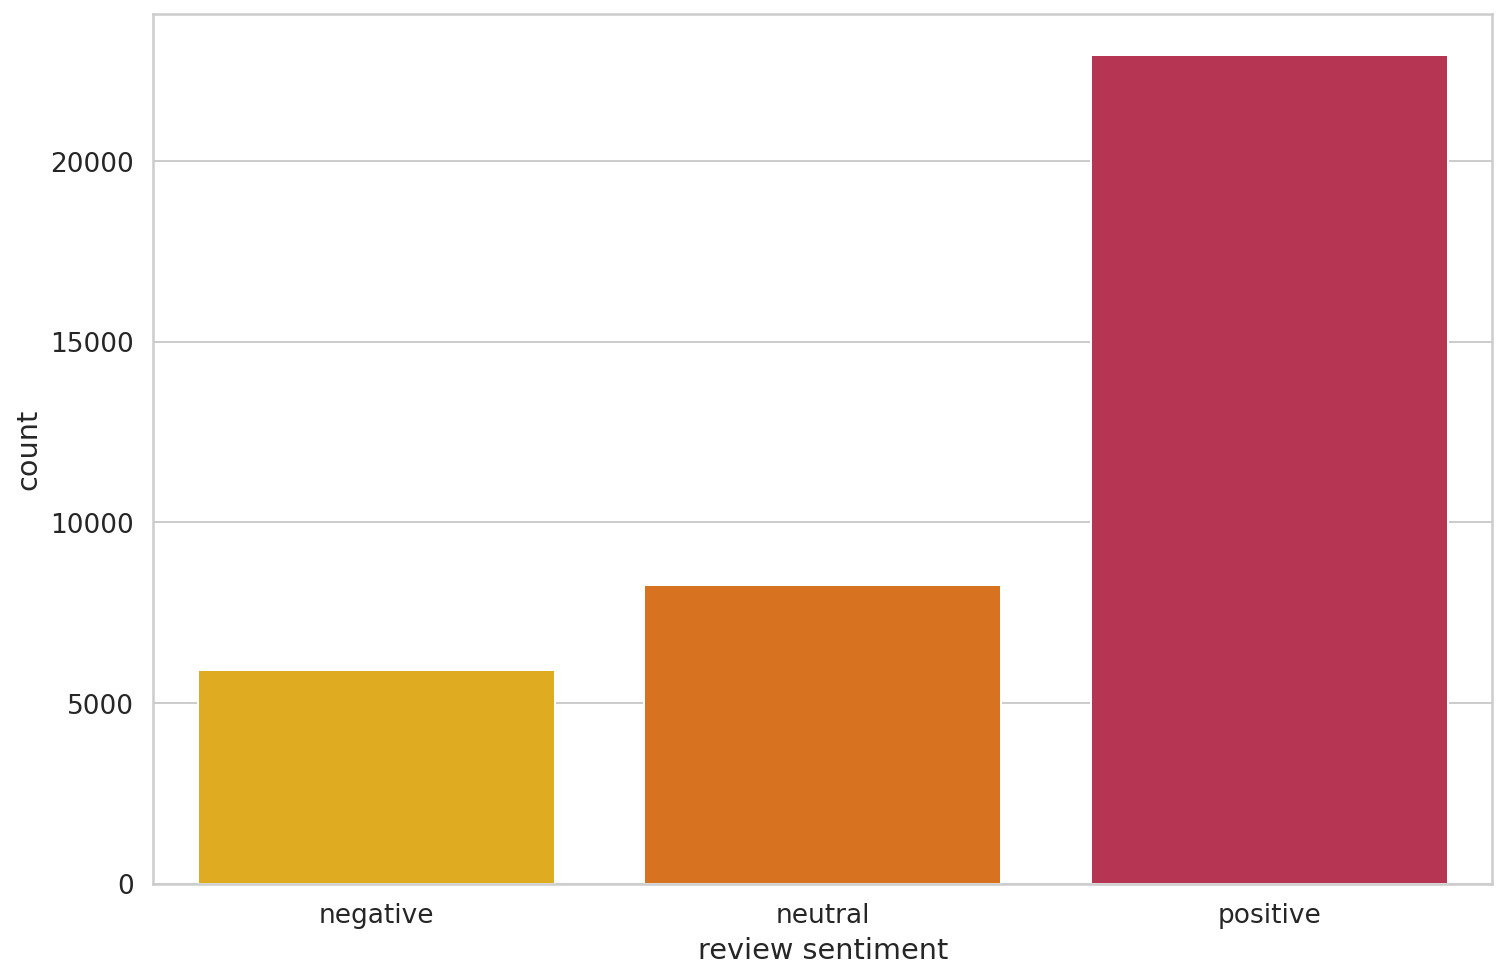

In [ ]:
ax1 = sns.countplot(amazon_df.sentiment)
plt.xlabel('review sentiment')
ax1.set_xticklabels(class_name)

In [ ]:
amazon_df.head()

,reviewText,overall,sentiment
0,I have super sensitive acne prone skin. I love...,4,1
1,This is the best invention since electricity!!,5,2
2,I am using it to clean through braces. it is s...,4,1
3,Serves the purpose but cat throw in your bag w...,3,1
4,I had high hopes for this travel brush. I'm a...,1,0


In [ ]:
youtube_df.head()

,Comment,overall,sentiment
0,Got the Monday blues? Love this song!!,0.78125,2
1,Am i the only one that came back after listeni...,0.00000,1
2,can’t believe this was over three years ago,0.00000,1
3,I love jisoo,0.50000,2
4,kim jon un when he imagines what his life woul...,0.00000,1


In [ ]:
# change the column name from amazon_df and youtube_df before merge
amazon_df = amazon_df.rename(columns = {"reviewText":"text"})
youtube_df = youtube_df.rename(columns = {"Comment":"text"})

In [ ]:
amazon_df.head()

,text,overall,sentiment
0,I have super sensitive acne prone skin. I love...,4,1
1,This is the best invention since electricity!!,5,2
2,I am using it to clean through braces. it is s...,4,1
3,Serves the purpose but cat throw in your bag w...,3,1
4,I had high hopes for this travel brush. I'm a...,1,0


In [ ]:
youtube_df.tail()

,text,overall,sentiment
3855,alguém ouvindo na quarentena?,0.000000,1
3856,╔┓┏╦━━╦┓╔┓╔━━╗\n║┗┛║┗━╣┃║┃║ 0 0 ║\n║┏┓║┏━╣┗╣┗╣...,0.000000,1
3857,This song does not fell like it was made that ...,-0.050000,0
3858,Yeah they wishin' and wishin' and wishin' and ...,-0.124138,0
3859,temazoooo saludos desde Gran Canaria,0.000000,1


In [ ]:
# combine two dataset
data = [amazon_df, youtube_df]
final_df = pd.concat(data)

In [ ]:
final_df

,text,overall,sentiment
0,I have super sensitive acne prone skin. I love...,4.000000,1
1,This is the best invention since electricity!!,5.000000,2
2,I am using it to clean through braces. it is s...,4.000000,1
3,Serves the purpose but cat throw in your bag w...,3.000000,1
4,I had high hopes for this travel brush. I'm a...,1.000000,0
...,...,...,...
3855,alguém ouvindo na quarentena?,0.000000,1
3856,╔┓┏╦━━╦┓╔┓╔━━╗\n║┗┛║┗━╣┃║┃║ 0 0 ║\n║┏┓║┏━╣┗╣┗╣...,0.000000,1
3857,This song does not fell like it was made that ...,-0.050000,0
3858,Yeah they wishin' and wishin' and wishin' and ...,-0.124138,0


In [ ]:
# load pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# check the tokenization process
sample_text = 'When corona situation finish? I am stuck at Ireland for 1 years.'

In [ ]:
# convert the text to tokens and tokens to unique integers(id)
token = tokenizer.tokenize(sample_text)
token_id = tokenizer.convert_tokens_to_ids(token)

print(f' Sentence: {sample_text}')
print(f' Tokens: {token}')
print(f' Token IDs: {token_id}')

 Sentence: When corona situation finish? I am stuck at Ireland for 1 years.
 Tokens: ['When', 'co', '##rona', 'situation', 'finish', '?', 'I', 'am', 'stuck', 'at', 'Ireland', 'for', '1', 'years', '.']
 Token IDs: [1332, 1884, 15789, 2820, 3146, 136, 146, 1821, 5342, 1120, 2270, 1111, 122, 1201, 119]


In [ ]:
# Special Tokens
# [SEP] - marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
# [CLS] - we must add this token to the start of each sentence, so BERT 
# knows we're doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
# special token for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# BERT understands tokens that were in the training set
# Everything else can be encoded using the [UNK] token
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
# all of the special tokens can be done using encode_plus()
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
# token ids are now stored in a Tensor and padded to a length of 32
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1332,  1884, 15789,  2820,  3146,   136,   146,  1821,  5342,
         1120,  2270,  1111,   122,  1201,   119,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
# attension mask has the same length
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# inverse the tokenization to have a look at the special tokens
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'co',
 '##rona',
 'situation',
 'finish',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'Ireland',
 'for',
 '1',
 'years',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
# BERT works with fixed-length sequences. 
# use the simple strategy to choose the max length
token_lens = []

for txt in final_df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

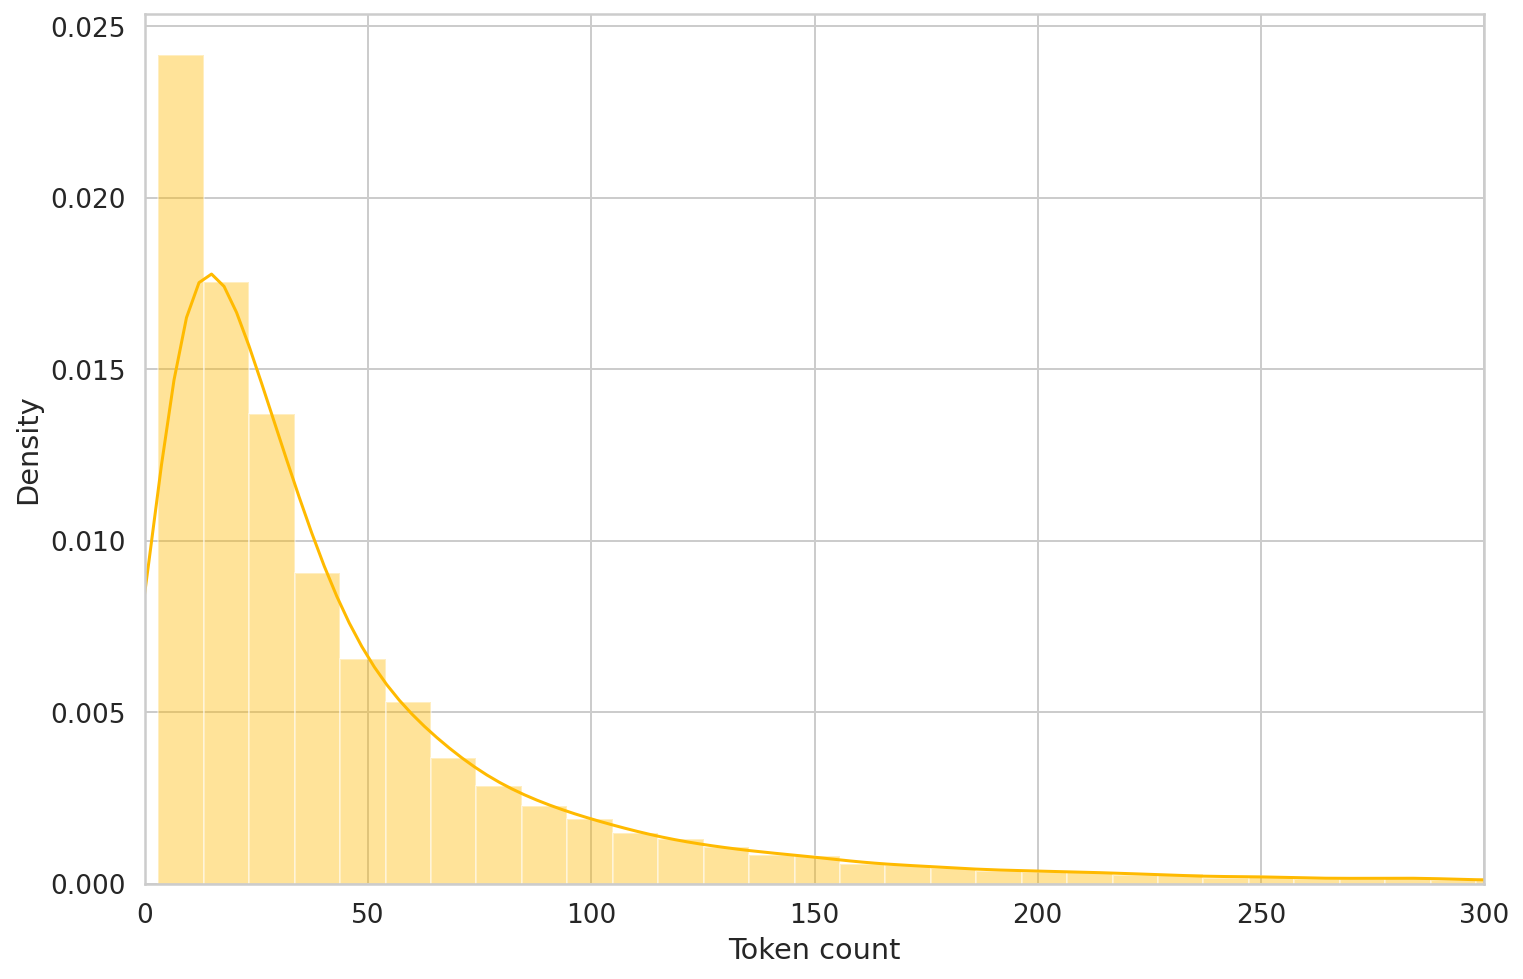

In [ ]:
# plot the distribution
sns.distplot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count');

In [ ]:
# most of the reviews seem to contain less than 300 tokens, but i will choose maximum length of 150
max_len = 150

In [ ]:
# have all building blocks required to create a PyTorch dataset
class buildBlockDataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }   

In [ ]:
# tokenizer is doing most of the heavy lifting 
# return the review texts, easy to evaluate the predictions from model
# split the data
df_train, df_test = train_test_split(final_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((36859, 3), (2048, 3), (2048, 3))

In [ ]:
# create a couple of data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    datast = buildBlockDataset(
        reviews=final_df.text.to_numpy(),
        targets=final_df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        datast,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
BATCH_SIZE = 15

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)

In [ ]:
# Let's batch from training data loader
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([15, 150])
torch.Size([15, 150])
torch.Size([15])


In [ ]:
# load the model
bert_model = BertModel.from_pretrained('bert-base-cased', return_dict=False)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# encoding of sample text 
# last_hidden_state is a sequence of hidden states of the last layer of the model
# pooled_output is done by applying the BertPooler on last_hidden_state
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
# have hidden state for each of 32 tokens (the length of example sequence)
# number of hidden units in the feedforward-networks
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
# classifier delegates most of the heavy lifting to the BertModel. 
# use a dropout layer for some regularization and a fully-connected layer for our output
# returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size,n_classes)
    
    def forward(self, input_ids, attention_mask):
        returned = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = returned["pooler_output"]
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# it should work like any other PyTorch model
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# move the example batch of training data to the GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape) 

torch.Size([15, 150])
torch.Size([15, 150])


In [ ]:
# get predicted probabilities from trained model, apply softmax function to outputs
func.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2400, 0.4415, 0.3185],
        [0.2682, 0.2674, 0.4644],
        [0.3610, 0.2609, 0.3781],
        [0.2101, 0.3885, 0.4014],
        [0.5093, 0.3333, 0.1573],
        [0.2368, 0.4094, 0.3538],
        [0.2693, 0.3421, 0.3886],
        [0.3979, 0.1982, 0.4039],
        [0.3728, 0.2340, 0.3932],
        [0.3114, 0.2639, 0.4248],
        [0.3035, 0.2362, 0.4603],
        [0.3418, 0.1983, 0.4599],
        [0.2099, 0.4073, 0.3828],
        [0.2963, 0.3103, 0.3934],
        [0.3297, 0.2535, 0.4168]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
# reproduce the training procedure from BERT paper, use the AdamW optimizer
# it correts weight decay, also use a linear scheduler with no warmup steps 
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Come up with all Hyperparameters. Recommendations for fine-tuning from BERT authors:

Batch size: 16, 32

Learning rate(Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2,3,4

In [ ]:
# increasing the batch size reduces the training time significantly but gives lower accuracy
# writing a helper function for training model for one epoch
# scheduler gets called every time a batch is fed to the model. avoid exploding gradients by 
# clipping the gradients of the model using clipgrad_norm
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  predictions = 0

  for data in data_loader:
    input_ids = data["input_ids"].to(device)
    attention_mask = data["attention_mask"].to(device)
    targets = data["targets"].to(device)
  
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return predictions.double() / n_examples, np.mean(losses)

In [ ]:
# evaluate the model on a given data loader
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  predictions = 0

  with torch.no_grad():
    for data in data_loader:
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["targets"].to(device)

      outputs = model(
          input_ids=input_ids, 
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      predictions += torch.sum(preds == targets)
      losses.append(loss.item())

    return predictions.double() / n_examples, np.mean(losses)

In [ ]:
# write training loop, we also store the training history 
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device, 
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Validation loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.534706385700487 accuracy 0.8753628693127866
Validation loss 0.8749338629246658 accuracy 14.96728515625

Epoch 2/10
----------
Train loss 0.3726054105141409 accuracy 0.9592229848883584
Validation loss 0.6043918264932768 accuracy 16.75390625

Epoch 3/10
----------
Train loss 0.2788843806709921 accuracy 1.0101196451341599
Validation loss 0.4060262517456205 accuracy 18.046875

Epoch 4/10
----------
Train loss 0.22223543129369946 accuracy 1.03933910306845
Validation loss 0.20950492242642446 accuracy 18.9814453125

Epoch 5/10
----------
Train loss 0.17980497740991527 accuracy 1.0580319596299412
Validation loss 0.13701835388760772 accuracy 19.31494140625

Epoch 6/10
----------
Train loss 0.151579442775522 accuracy 1.0670121272959114
Validation loss 0.10293207341525977 accuracy 19.462890625

Epoch 7/10
----------
Train loss 0.1164940426795095 accuracy 1.077484467836892
Validation loss 0.07641524136051112 accuracy 19.5849609375

Epoch 8/10
----------
Train los

In [ ]:
history_train_acc = torch.tensor(history['train_acc'], device = 'cpu')

In [ ]:
history_val_acc = torch.tensor(history['val_acc'], device = 'cpu')

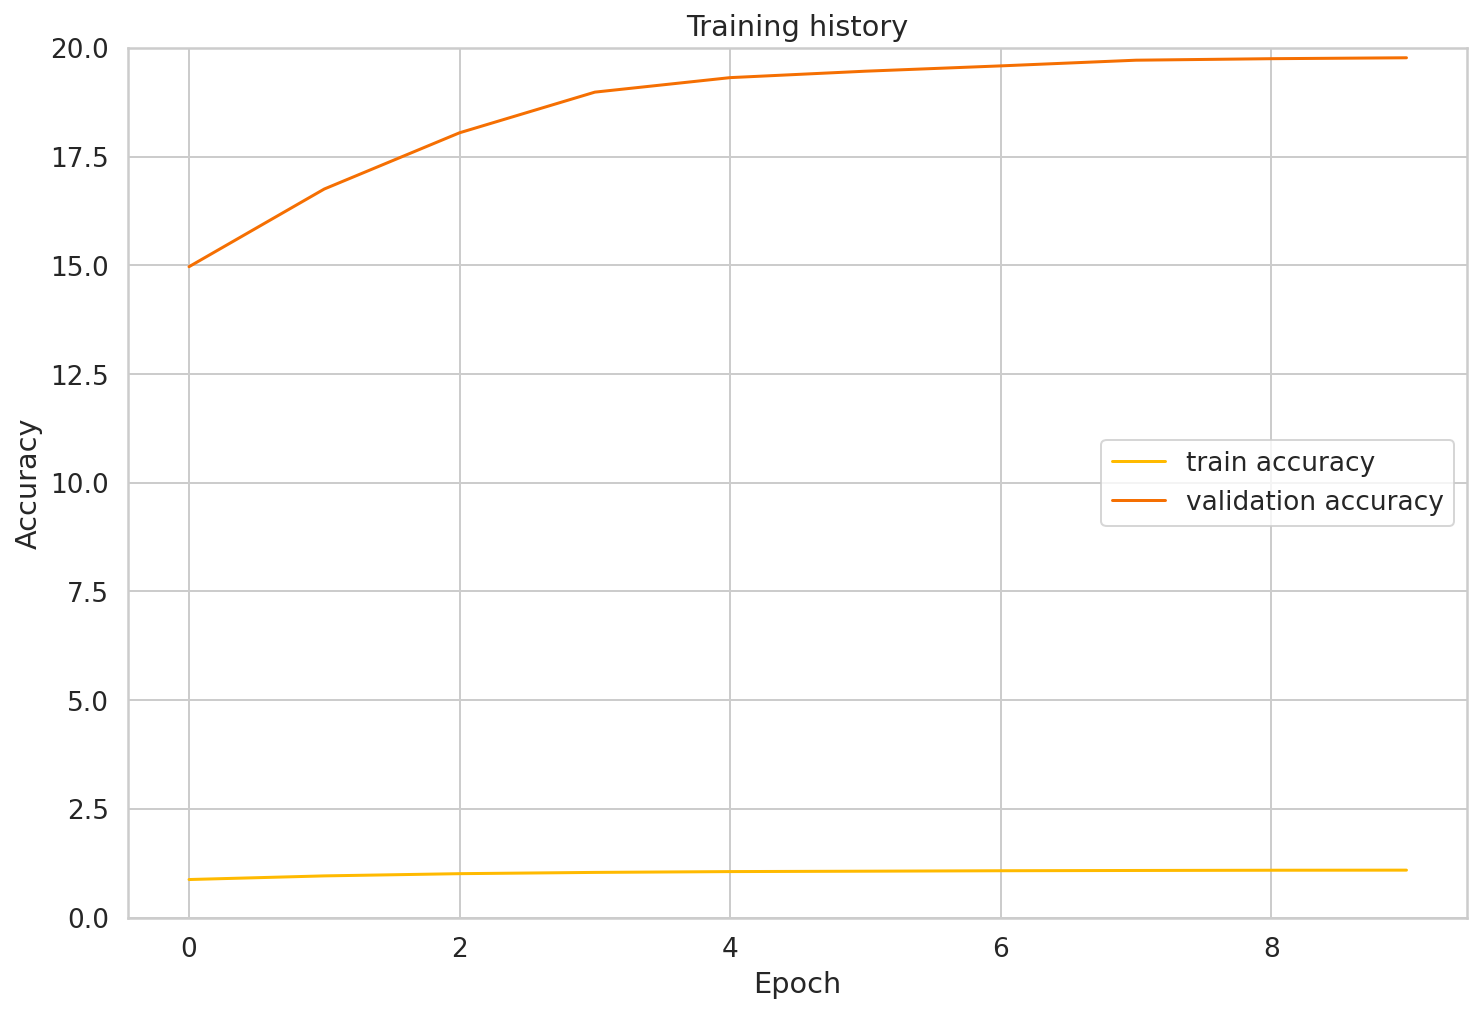

In [ ]:
# look at the training vs validation accuracy
plt.plot(history_train_acc, label='train accuracy')
plt.plot(history_val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 20]);

In [ ]:
# evaluation - calculate the accuracy on the test data
test_accuracy, _ = eval_model(
    model, 
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_accuracy.item()

19.771484375

In [ ]:
# define a helper function to get the predictions 
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  values = torch.stack(values).cpu()
  return review_texts, predictions, prediction_probs, values

In [ ]:
# similar to the evaluation function except that im storing the text of the reviews and the predicted probabilites
y_review_text, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
# classification report 
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    negative       1.00      0.99      0.99      6345
     neutral       0.99      0.97      0.98     10331
    positive       0.99      1.00      0.99     24279

    accuracy                           0.99     40955
   macro avg       0.99      0.99      0.99     40955
weighted avg       0.99      0.99      0.99     40955



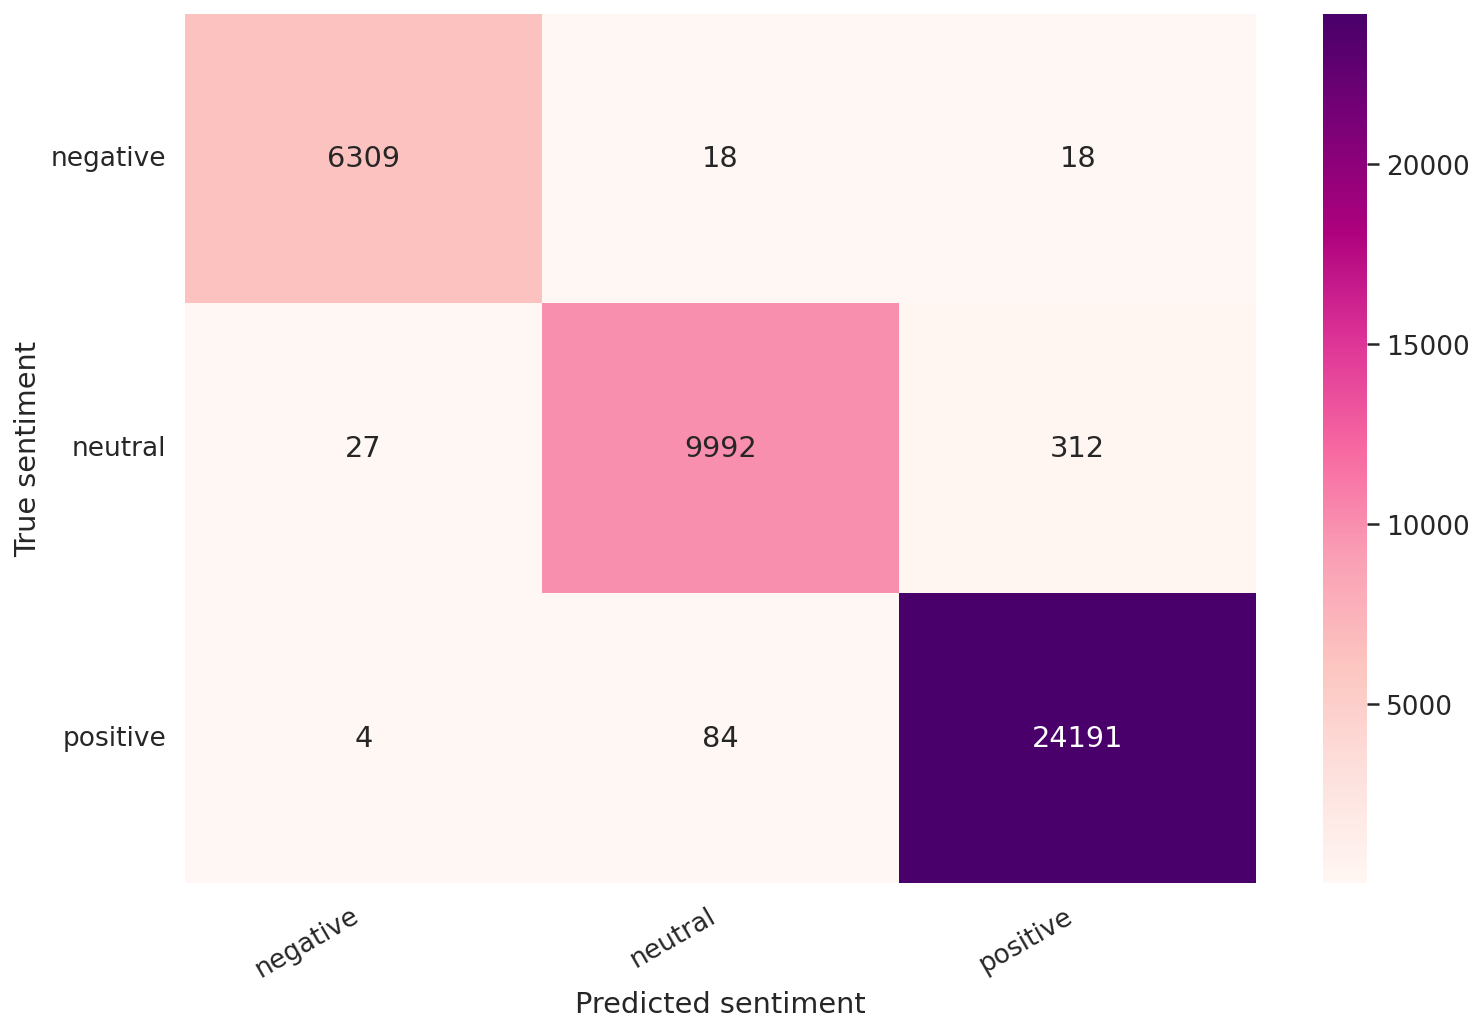

In [ ]:
# confusion matrix
def get_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="RdPu")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

cfm = confusion_matrix(y_test, y_pred)
df_cfm = pd.DataFrame(cfm, index=class_name, columns=class_name)
get_confusion_matrix(df_cfm)

In [ ]:
# model is having difficulty classifying neutral reviews. 
# look at an example from test data
index = 3

review_text = y_review_text[index]
sentiment_result = y_test[index]
pred_df = pd.DataFrame({
    'class_name': class_name,
    'values': y_pred_probs[index]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'sentiment result: {class_name[sentiment_result]}')

Serves the purpose but cat throw in your bag without something to
protect it. The coating gets scratched then the oils are exposed to
light.

sentiment result: neutral


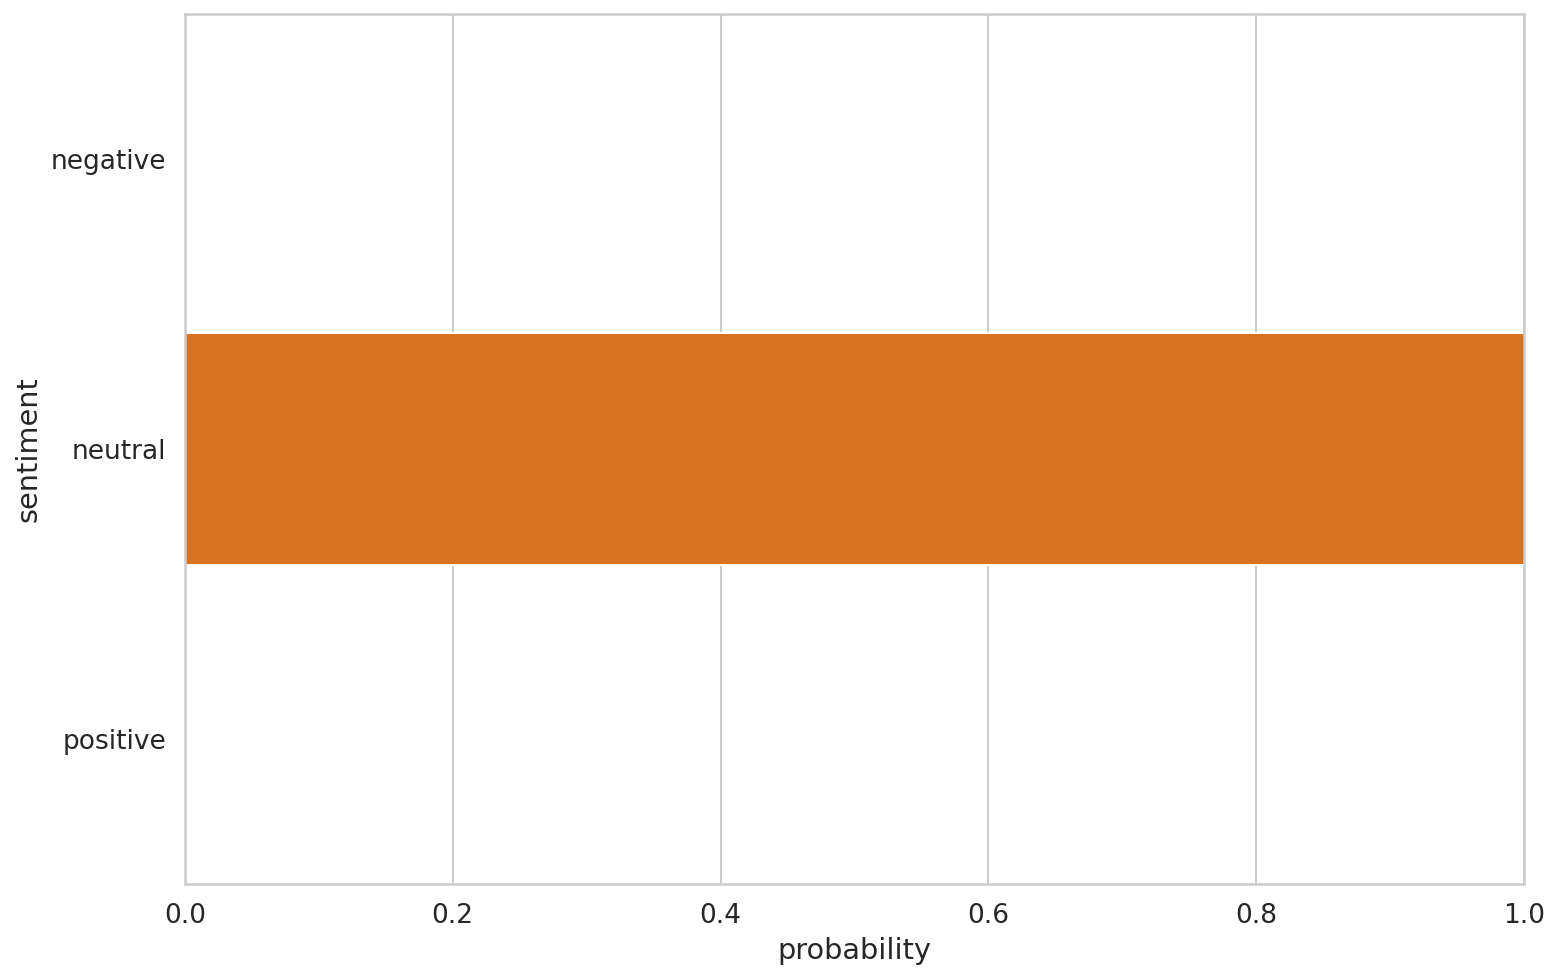

In [ ]:
# check the confidence of sentiment of model
sns.barplot(x='values', y='class_name', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0,1]);

In [ ]:
# finally use model to predict sentiment of raw text
customer_review = "Don't buy!: First of all, the company took my money and sent me an email telling me the product was shipped. A week and a half later I received another email telling me that they are sorry, but they don't actually have any of these items, and if I received an email telling me it has shipped, it was a mistake."

In [ ]:
# use tokenizer to encode text
encoded_review = tokenizer.encode_plus(
    customer_review,
    max_length=max_len,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
# prediction
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Customer Review: {customer_review}')
print(f'Sentiment Analysis Result: {class_name[prediction]}')

Customer Review: Don't buy!: First of all, the company took my money and sent me an email telling me the product was shipped. A week and a half later I received another email telling me that they are sorry, but they don't actually have any of these items, and if I received an email telling me it has shipped, it was a mistake.
Sentiment Analysis Result: negative
